# Formula 1 2019 performance metrics

# 0. Introduction
 
 
-> put this in readme 
Formula 1 (F1) is an open-wheel racing series considered by many to be the pinacle of motorsport. Although largely seen as a Eurpoean sport, F1 races (Grand Prix) are held anually all over the world.  

This project uses the F1 dataset found on [kaggle](https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020) to explore some statistics from the 2019 F1 season. In future updates, this will be expanded to include all years for which there was substantial data. 

This project is largely inspired by the question: to what extent is performance in F1 due to driver talent vs. car performance? F1 teams are requried to develop their own cars, and as a result, the most dominate teams are usually the ones with the most money to dedicate towards research and development. This question has been endlessly debated among pundits, and has been the subjest of entire [blogs](https://f1metrics.wordpress.com/) and even some research papers.

While I don't expect to get a definitive answer through this project, I would like to explore some of the factors that go into adressing this question, mainly: positions gained / lost during a race, reliability, and consistency. 

TODO: point out driver change in 2019
TODO: start with plot of driver name, code, and finshing results

This project has been divided into 6 sections: 

#### 1) Race Traces  
Draw the cumulative lap times over the course of 1 race (inspired by [jtrotman's](https://www.kaggle.com/jtrotman/f1-race-traces-2020) contribution. This includes a breakdown of the race traces by team to measure teammate head-to-head performance.

#### 2) Finishing position vs. start position  
Look at the spread of positions gained / lost during a race. This is a good way to evaluate the performance of midfield drivers. 

#### 3) Retirements 
Who has been involved in the most crashes and who has had the worst reliability? 

#### 4) Consistency
Here, I propose that one way to measure the talent of a driver is to measure their consistency. One way to measure consistency is to measure the distribution of lap times. The idea here is that the better driver will get maximum performance out of the car lap after lap after lap- which should mean a smaller spread in lap times when aggregated over the course of an entire season. I will do this by doing the following: 

- filter out the first lap of each race, pit stops, out-laps, and safety cars

- visualize the distribution of lap times of each driver over a given race

- calculate the coefficient of variation (standard deviation / average) of the lap times for each race

- plot the coeffients of variation for each race during a given season 

#### 5) Conclusion
Summary of results

#### 6) Future updates
A list of features and analyses that I intend to add



============OLD==============================================================
The F1 field is divided into teams (aka constructors). There are 2 drivers per team with identical cars, and presently 10 teams on the grid. Constructors are required to innovate and build their own car according to the regulations- although they are allowed to buy and sell parts from other teams. This means that in general, the teams with the best funding dominate. 

The F1 season consists of two championships: the drivers and constructors championship. Points are awarded at the end of each race based on driver perfomance. The driver with the most points at the end of the year wins the drivers championship, and the points from each driver in the team are added together for the constructors championship. 

For some context, Mercedes has been the most dominate team since 2014, having won 7 back-to-back constructors championships. Mercedes driver Lewis Hammilton is statistically one of the greatest F1 drivers of all time, having just won his 7th driver's title this past year. It is expected that Mercedes will continue this domination into 2021, allowing Hamilton to secure his 8th driver's title, the most of any driver in F1 history. 

All this discussion about constructor performance begs an interesting question: To what extent is overall performance due to the car vs. driver talent? This has been the subject of nearly endless debate between pundits, and entire Entire  and even some research papers have been dedicated to answering this question. 

The purpose of this project is twofold: First, I need to learn SQL and this F1 dataset from kaggle provides an excellent opportunity for practice. Second, I will weigh in on this discussion by analyzing the kaggle dataset for myself- and take a stab at addressing this question by analyzing driver consistency. 

put somewhere up here: Since each team has a different car, the only direct way to compare drivers is to compare teammates. In a future update, I plan to turn this into an interactive dashboard to view results by race and by season.  

In this notebook, I will primarily focus on the 2019 season- however further on I plan to combine these features into an interactive dashboard to study historical data. 

In this notebook, I conduct 4 analyses and investigate 3 different metrics on this F1 dataset to analyze the best performers of the 2019 season. 

In [1]:
# basics
import numpy as np
import pandas as pd
import math

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns

# Sql
from psycopg2 import connect, extensions, sql

# other
from datetime import datetime, time, date
from collections import defaultdict

# Load login info for postgres. 
with open("postgres_login_info.txt") as f: 
    login_info = f.read()
mpl.rcParams['figure.max_open_warning'] = 50

%config InlineBackend.figure_format = 'svg'

Define a function the queries the database.

In [2]:
def query(text):
    """Run a query on the Formula_1_statistics database using the text input
    Parameters
    ---------
    text: SQL code to run
    
    Returns
    ---------
    df: DataFrame containing the result of the submitted query
    
    """
    with connect(login_info) as conn, conn.cursor() as cur:  
        autocommit = extensions.ISOLATION_LEVEL_AUTOCOMMIT
        conn.set_isolation_level(autocommit)
        
        query = sql.SQL(text)
        cur.execute(query)
        return pd.DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

For plotting, define a few dictionaries for team colors and abreviations.

In [3]:
colors = defaultdict(lambda: '#FFFFFF', {
                     'Mercedes'      : '#00D2BE', 
                     'Ferrari'       : '#C00000', 
                     'Red Bull'      : '#0600EF', 
                     'Renault'       : '#FFF500', 
                     'Haas F1 Team'  : '#787878', 
                     'Racing Point'  : '#F596C8', 
                     'Force India'   : '#F596C8', 
                     'AlphaTauri'    : '#C8C8C8',
                     'Toro Rosso'    : '#469BFF',
                     'McLaren'       : '#FF8700', 
                     'Alfa Romeo'    : '#960000',
                     'Sauber'        : '#960000',
                     'Williams'      : '#0082FA', 
                     'Lotus F1'      : '#FFB800',
                     'Manor Marussia': '#6E0000'
                    })

team_abbrev = defaultdict(lambda: 'NA', {
                     'Mercedes'      : 'Merc', 
                     'Ferrari'       : 'Fer', 
                     'Red Bull'      : 'RB', 
                     'Renault'       : 'Ren', 
                     'Haas F1 Team'  : 'Has', 
                     'Racing Point'  : 'RP', 
                     'Force India'   : 'FI', 
                     'AlphaTauri'    : 'AT', 
                     'Toro Rosso'    : 'TR', 
                     'McLaren'       : 'McL', 
                     'Alfa Romeo'    : 'AR', 
                     'Sauber'        : 'Sau', 
                     'Williams'      : 'Wil',
                     'Lotus F1'      : 'Lot', 
                     'Manor Marussia': 'MM'
                    })

Write a few queries to get the lap times during a race

In [4]:
def get_lap_distribution(firstname=None, lastname=None, driverref=None, code=None, race=None, year=None):
    """Query the database to get the lap time distribution for 1 driver over the course of 1 race. 
    
    Parameters 
    ---------
    firstname: string
        driver's first name
    lastname: string
        driver's last name
    driverref: string
        driver reference- can substitute for first name and last name (e.g. pass driverref="hamilton" instead of 
        firstname="Lewis", lastname="Hamilton")
    code: string
        3 letter driver reference
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
        
    Returns
    ---------
    DataFrame with lap times and driver information
    """
    
    
    text = f"""
    
    -- Get a list of lap times for the specific race
    WITH times AS (SELECT EXTRACT(MINUTES FROM lap_times.time)*60 +
                            EXTRACT(SECONDS FROM lap_times.time) AS lap_time, 
                        lap_times.lap, 
                        lap_times.position, 
                        lap_times.driverid, 
                        lap_times.raceid,
                        EXTRACT(YEAR FROM races.date) AS year
                 FROM lap_times 
                 JOIN races ON lap_times.raceid = races.raceid 
                 JOIN circuits ON races.circuitid = circuits.circuitid
                 WHERE ((races.name iLike '%{race}%') AND year = {year})
                 ),
   
   -- Get the pit stops. 
    pits AS (SELECT pit_stops.driverid, 
                    pit_stops.raceid, 
                    pit_stops.stop, 
                    pit_stops.lap AS pit_lap, 
                    pit_stops.time, 
                    pit_stops.duration
             FROM pit_stops
             JOIN races ON pit_stops.raceid = races.raceid
             JOIN drivers ON pit_stops.driverid = drivers.driverid
             WHERE(
                  (races.name iLike '%{race}%') 
                   AND year = {year}
                   AND ((drivers.forename iLike '%{firstname}%'
                       AND drivers.surname iLike '%{lastname}%') 
                        OR drivers.driverref iLike '%{driverref}%'
                        OR drivers.code iLike '%{code}%')
                  )
    ), 
    
    average_lap AS (SELECT AVG(times.lap_time) AS time FROM times) 
              
              
    SELECT lap_times.lap,
           EXTRACT(MINUTES FROM lap_times.time)*60 + EXTRACT(SECONDS FROM lap_times.time) AS lap_time,
           CASE
               WHEN lap_times.lap IN (SELECT pits.pit_lap FROM pits) THEN TRUE
               ELSE FALSE
           END AS pit_lap, 
           lap_times.position,
           drivers.forename, 
           drivers.surname, 
           drivers.code, 
           races.name, 
           races.year, 
           status.status
           
    FROM lap_times
    
    JOIN drivers ON drivers.driverid = lap_times.driverid
    JOIN races ON races.raceid       = lap_times.raceid
    JOIN results ON results.raceid   = lap_times.raceid
    JOIN status ON results.statusid  = status.statusid
    
    WHERE(
        
        -- filter drivers
        ((drivers.forename iLike '%{firstname}%'
        AND drivers.surname iLike '%{lastname}%')
        OR drivers.driverref iLike '%{driverref}%'
        OR drivers.code iLike '%{code}%')
        
        -- filter results
        AND results.driverid = (
                SELECT driverid
                FROM drivers
                WHERE ((drivers.forename iLike '%{firstname}%'
                        AND drivers.surname iLike '%{lastname}%')
                        OR drivers.driverref iLike '%{driverref}%'
                        OR drivers.code iLike '%{code}%')
                LIMIT 1
                )

        -- filter races
        AND races.name iLike '%{race}%' AND races.year = {year}
    ) 
    """
    
    
    return query(text)

In [5]:
get_lap_distribution(code="HAM", race="British", year=2020).head()

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status
0,1,94.010,False,1,Lewis,Hamilton,HAM,British Grand Prix,2020,Finished
1,2,126.445,False,1,Lewis,Hamilton,HAM,British Grand Prix,2020,Finished
2,3,151.201,False,1,Lewis,Hamilton,HAM,British Grand Prix,2020,Finished
3,4,152.874,False,1,Lewis,Hamilton,HAM,British Grand Prix,2020,Finished
4,5,138.933,False,1,Lewis,Hamilton,HAM,British Grand Prix,2020,Finished


In [6]:
def get_race_distribution(race, year):
    
    """Query a dataframe to get the lap times of every driver on the grid over the course of a race. 
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
        
    Returns
    ---------
    DataFrame with lap times and driver information for every drive during a race
    
    """
    
    text = f"""

    SELECT drivers.forename AS firstname,
           drivers.surname AS lastname,
           drivers.code, 
           drivers.driverid, 
           drivers.driverref,
           results.positionorder,
           races.name AS race_name, 
           constructors.name AS team
           
    FROM drivers
    
    JOIN results ON results.driverid = drivers.driverid
    JOIN races ON races.raceid = results.raceid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = {year} AND races.name iLike '%{race}%'
    """
    
    drivers_df =  query(text);

    frames = [get_lap_distribution(driverref=ref, race=race, year=year) 
              for ref in drivers_df['driverref']];
    
    # replace none with Nan (this happened with Sainz in the 2019 Belgian grand prix- retired on first lap)
    df = pd.concat(frames, ignore_index=True).sort_values(by="lap_time")
    df['team'] = [drivers_df[drivers_df['code'] == i]['team'].values[0] for i in df['code']]
    df.fillna(value=np.nan, inplace=True)
    
    return df

In [7]:
get_race_distribution(race="British", year=2019)

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status,team
51,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes
56,47,87.406,False,2,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished,Mercedes
58,49,88.399,False,2,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished,Mercedes
54,45,88.545,True,2,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished,Mercedes
40,41,88.568,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes
...,...,...,...,...,...,...,...,...,...,...,...
280,21,144.703,False,7,Carlos,Sainz,SAI,British Grand Prix,2019,Finished,McLaren
332,21,146.118,False,11,Daniel,Ricciardo,RIC,British Grand Prix,2019,Finished,Renault
798,21,149.502,False,3,Sebastian,Vettel,VET,British Grand Prix,2019,+1 Lap,Ferrari
907,1,159.140,True,20,Kevin,Magnussen,MAG,British Grand Prix,2019,Collision,Haas F1 Team


# 1 Race traces

Plot the evolution of lap times in relation to the average cumulative lap time

In [8]:
def get_race_trace(race=None, year=None, make_plot=True): 
    """Function to plot the race traces. 
    
    Calculate the average cumulative lap time for each lap. For example, if the average lap times for the first 3 laps 
    of a hypothetical race were 95, 85, and 86 seconds, then the average cumulative lap times would be 95, 180, and 266
    seconds. Then, for each driver, calculate the difference between the driver's cumulative lap time and the average 
    (called the delta). A negative delta indicates that the driver has a faster pace than the average lap. 
    
    
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
    make_plot: 
        If true, will generate a plot of the race traces for a given race and return the axis handles.
        
    Returns
    ---------
    DataFrame 
        The associated race distribution
    Series
        the average cumulative lap time of each lap
    axis (optional)
        axis handles of the plot, if make_plot is True
    """
    
    # Get the race data. 
    df = get_race_distribution(race=race, year=year).sort_values(by=['code', 'lap'])
    
    # Declare a new column with the differences from the average
    df['delta'] = np.nan
    
    laps = df['lap'].sort_values().unique()
    
    # Calculate the average cumulative lap time. 
    time = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps]).cumsum(skipna=True)
        
    # Set up plot parameters. 
    if make_plot == True: 
        linetypes = ["-", "--"]
        sns.set_style("darkgrid")
        fig, ax = plt.subplots(figsize=[10, 8])
    
    for team in df['team'].unique(): 
        drivers = df['code'][df['team'] == team].unique()
        
        for i in range(len(drivers)):     
            # Calculate the difference between the driver's cumulative time and average cumulative time. 
            delta = pd.Series([df['lap_time'][(df['code'] == drivers[i]) & (df['lap'] == lap)].values[0]
                               for lap in laps if
                               len(df['lap_time'][(df['code'] == drivers[i]) & (df['lap'] == lap)]) > 0]
                             ).cumsum(skipna=True) - time
            
            # Update the DataFrame (TODO: there should be a more pythonic way to do this). 
            for lap in laps:
                df.loc[(df['code'] == drivers[i]) & (df['lap'] == lap), 'delta'] = delta[lap-1]
            
            # Skip this part if no plot. 
            if make_plot == False: 
                continue
            
            # Use the legend to indicate drivers that retired or finished a lap down.
            if df['status'][(df['code'] == drivers[i])].values[0] != "Finished": 
                label = drivers[i] + " (" + df['status'][df['code'] == drivers[i]].values[0] + ")"
            else: 
                label = df['code'][df['code'] == drivers[i]].values[0]
                
            # Draw the plot.     
            plt.plot(delta, 
                     color=colors[df['team'][df['code'] == drivers[i]].values[0]], 
                     label=label, 
                     linestyle=linetypes[i],
                     linewidth=1)
    # Format fiture. 
    if make_plot == True:
        ax.set_title(f"race traces for the {year} {df['name'].values[0]}")
        ax.set_xlabel("lap")
        ax.set_ylabel("delta (seconds)")
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1, fontsize=10)    
        return df, time, ax
    
    else: 
        return df, time

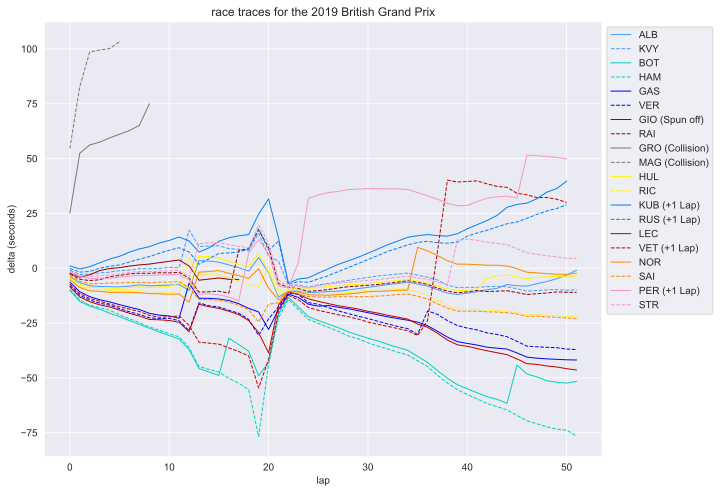

In [9]:
get_race_trace(race="British", year=2019, make_plot=True);

First of all, we can see that a couple lines are cut off due to retirements (GRO and MAG). Several lines end just before the others since they finished a lap down, so they completed fewer laps overall. Spikes in the delta are inicative of pit stops, while the sudden reduction in the spread around lap 20-23 indicates a safety car. 

Now compare the performance between teammates by splitting this race trace by team

In [10]:
def plot_team_trace(race=None, year=None):     
    """Function to plot the race traces split by team. 
    
    Use get_race_trace() to calculate the deltas, the make the plot with one team for each subplot. 
    
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
        
    Returns
    ---------
    DataFrame 
        The associated race distribution
    Series
        the average cumulative lap time of each lap
    axis
        axis handles of the plot
    """
    
    # Get race data. 
    df, time = get_race_trace(race=race, year=year, make_plot=False)
    
    # Format plot. 
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(nrows=len(df['team'].unique()), figsize=[8, 24], sharex=True)
    plt.subplots_adjust(hspace=0.5)
    laps = df['lap'].sort_values().unique()
    linetypes = ["-", "--"]
    
    # Loop through each team. 
    for index, team in pd.Series(df['team'].unique()).items(): 
        drivers = df['code'][df['team'] == team].unique()
        
        # Loop through each driver in the team. 
        for i in range(len(drivers)): 
            
            # Configure labels. 
            if df['status'][(df['code'] == drivers[i])].values[0] != "Finished": 
                label = drivers[i] + " (" + df['status'][df['code'] == drivers[i]].values[0] + ")"
            else: 
                label = df['code'][df['code'] == drivers[i]].values[0]
            
            # Draw plot. 
            ax[index].plot(df['delta'][df['code'] == drivers[i]].values, 
                    color=colors[df['team'][df['code'] == drivers[i]].values[0]], 
                    linestyle=linetypes[i], 
                    label=label, 
                    linewidth=1)
            
            # Format axes. 
            ax[index].set_title(f"{team}")
            ax[index].set_ylabel("delta (seconds)")
            ax[index].legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=10)
            ax[index].xaxis.set_major_locator(ticker.MultipleLocator(5))
    
    # Format figure. 
    ax[-1].set_xlabel("lap")
    fig.suptitle(f"Race traces subdivided by team for the {year} {df['name'].values[0]}", fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.955)
    
    return df, time, ax

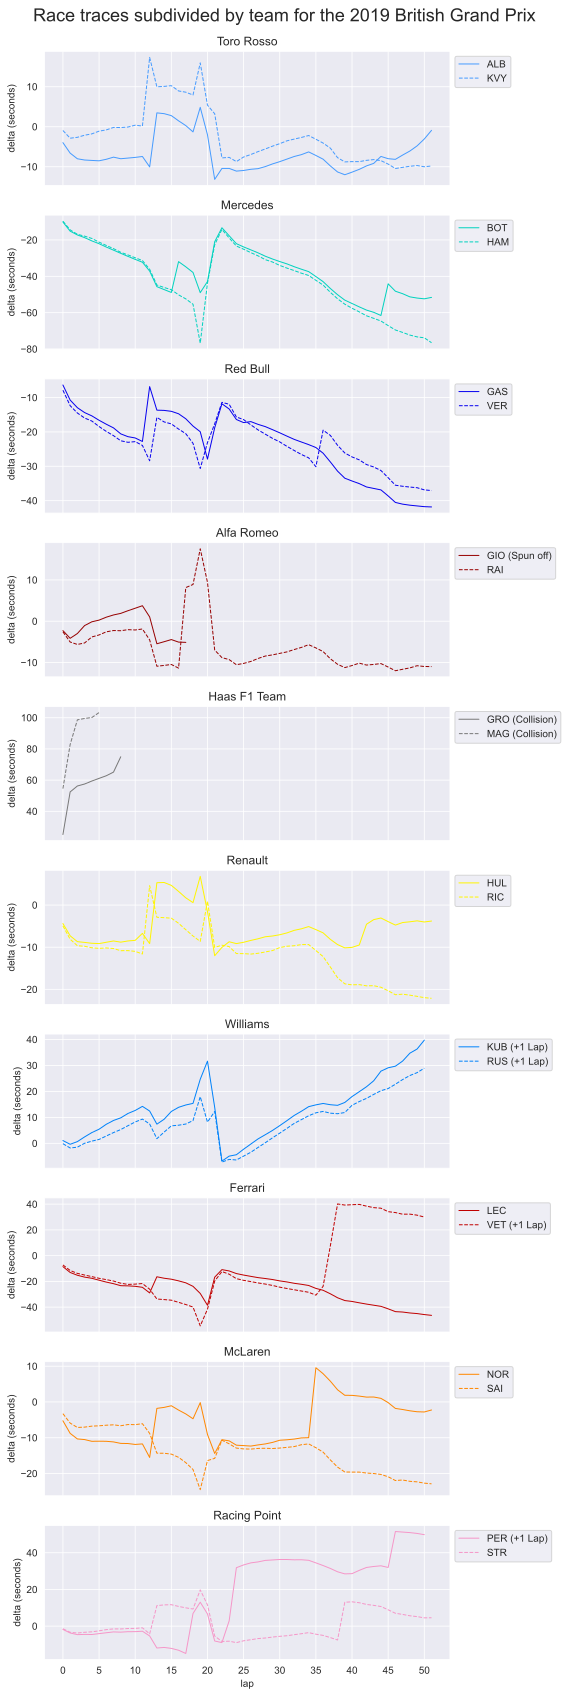

In [11]:
plot_team_trace(race="British", year=2019);

(detail findings here)

# 2 Finishing position vs. grid position

A relatively simple way to quantify the quality of an F1 driver is to look at their average qualifying position, finishing position, and positions gained / lost during a race. 

Start by writing a query to get the race results. 

In [12]:
def get_race_results(race=None, year=None): 
    """Get the results from one race. 
    
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: integer
        year in which the race occured
        
    Returns
    ---------
    DataFrame 
        The associated result data
    """
        
    text = f"""
    SELECT drivers.forename, 
           drivers.surname,
           drivers.code, 
           constructors.name AS team, 
           races.name,
           results.grid, 
           results.position, 
           results.positiontext, 
           results.points, 
           results.laps, 
           results.fastestlap, 
           results.fastestlaptime, 
           status.status
            
    FROM RESULTS
    
    JOIN drivers ON results.driverid = drivers.driverid
    JOIN races ON results.raceid = races.raceid
    JOIN status ON results.statusid = status.statusid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = {year} AND races.name iLike '%{race}%'
    """
    return query(text)

In [13]:
get_race_results(race="British", year=2019).head()

,forename,surname,code,team,name,grid,position,positiontext,points,laps,fastestlap,fastestlaptime,status
0,Lewis,Hamilton,HAM,Mercedes,British Grand Prix,2,1.0,1,26,52,52,00:01:27.369000,Finished
1,Valtteri,Bottas,BOT,Mercedes,British Grand Prix,1,2.0,2,18,52,47,00:01:27.406000,Finished
2,Charles,Leclerc,LEC,Ferrari,British Grand Prix,3,3.0,3,15,52,47,00:01:29.313000,Finished
3,Pierre,Gasly,GAS,Red Bull,British Grand Prix,5,4.0,4,12,52,48,00:01:29.544000,Finished
4,Max,Verstappen,VER,Red Bull,British Grand Prix,4,5.0,5,10,52,45,00:01:29.272000,Finished


Next, aggregate these results to the entire sesason. 

We will also need a short function to handle team changes (e.g. the [team switch](https://www.formula1.com/en/latest/article.analysis-why-red-bull-made-their-latest-blockbuster-driver-swap.5OSpVBQ1sdbxO5VEj80ykZ.html) between Pierre Gasley and Alex Albon in 2019). 

In [14]:
def team_switches(df): 
    """Append team abbreviation to 'code' if any driver has driven for more than 1 team during a season."""
    
    for driver in df['code']: 
        if len(df['team'][df['code'] == driver].unique())>1: 
            for team in df['team'][df['code'] == driver].unique(): 
                df.loc[(df['code'] == driver) & (df['team'] == team), 'code'] = f"{driver}\n({team_abbrev[team]})"
    return df

def get_season_results(year=None, min_races=3, team_change=True): 
    """Get the results from one race. 
    
    Parameters 
    ---------
    year: integer
        Season of interest
    min_races: integer
        In some season, a reserve driver had to stand in in-place of a full-time driver due to injury or illness. Filter
        these out if they've only driven in a few races (3 by default) since there won't be enough data
    Returns
    ---------
    DataFrame 
        the associated season data
    """
    
    # Get a list of races. 
    text = f"""
    SELECT races.name
    FROM races
    WHERE races.year = {year}
    """
    races = query(text).to_numpy()
    df = pd.DataFrame()
    
    # Loop through races and append results. 
    for race in races: 
        df = df.append(get_race_results(race=race[0], year=year), ignore_index=True)
        
    # If a driver only drove for a team in a limited number of races, drop those results.
    for team in df['team'].unique(): 
        for code in df['code'][df['team']==team].unique(): 
            if len(df['name'][(df['code']==code) & (df['team']==team)]) < min_races: 
                df = df.drop(df[(df['team']==team) & (df['code']==code)].index)
    
    # if 0 is in 'grid', set it to 20 (likely no time set- found with RAI in Italian GP 2019)
    df.loc[df['grid'] == 0, 'grid'] = 20
    
    # Account for team changes. 
    if team_change: 
        df = team_switches(df)
    return df

In [15]:
get_season_results(year=2019)

,forename,surname,code,team,name,grid,position,positiontext,points,laps,fastestlap,fastestlaptime,status
0,Valtteri,Bottas,BOT,Mercedes,Australian Grand Prix,2,1.0,1,26,58,57.0,00:01:25.580000,Finished
1,Lewis,Hamilton,HAM,Mercedes,Australian Grand Prix,1,2.0,2,18,58,57.0,00:01:26.057000,Finished
2,Max,Verstappen,VER,Red Bull,Australian Grand Prix,4,3.0,3,15,58,57.0,00:01:26.256000,Finished
3,Sebastian,Vettel,VET,Ferrari,Australian Grand Prix,3,4.0,4,12,58,16.0,00:01:27.954000,Finished
4,Charles,Leclerc,LEC,Ferrari,Australian Grand Prix,5,5.0,5,10,58,58.0,00:01:26.926000,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,Antonio,Giovinazzi,GIO,Alfa Romeo,Abu Dhabi Grand Prix,16,16.0,16,0,54,28.0,00:01:43.256000,+1 Lap
416,George,Russell,RUS,Williams,Abu Dhabi Grand Prix,18,17.0,17,0,54,50.0,00:01:43.074000,+1 Lap
417,Pierre,Gasly,GAS\n(TR),Toro Rosso,Abu Dhabi Grand Prix,11,18.0,18,0,53,53.0,00:01:42.414000,+2 Laps
418,Robert,Kubica,KUB,Williams,Abu Dhabi Grand Prix,19,19.0,19,0,53,51.0,00:01:44.500000,+2 Laps


In [16]:
def get_final_season_results(year=2019, res="driver"): 
    """Get the final season results for the drivers or team championship"""
    
    if res == "driver": 
        text = f"""
        SELECT --driver_standings.driverstandingsid AS id,
               drivers.forename, 
               drivers.surname, 
               drivers.code,  
               driver_standings.points,
               driver_standings.wins
        FROM driver_standings
        JOIN races ON driver_standings.raceid = races.raceid
        JOIN drivers ON driver_standings.driverid = drivers.driverid
        WHERE races.year = {year}
        AND races.round = (SELECT MAX(round) FROM races WHERE races.year={year})
        ORDER BY driver_standings.points DESC
        """
    elif res == "constructor": 
                text = f"""
        SELECT constructors.name,  
               constructor_standings.points,
               constructor_standings.wins
        FROM constructor_standings
        JOIN races ON constructor_standings.raceid = races.raceid
        JOIN constructors ON constructor_standings.constructorid = constructors.constructorid
        WHERE races.year = {year}
        AND races.round = (SELECT MAX(round) FROM races WHERE races.year={year})
        """
            
    return query(text)

In [17]:
get_final_season_results(year=2019)

,forename,surname,code,points,wins
0,Lewis,Hamilton,HAM,413,11
1,Valtteri,Bottas,BOT,326,4
2,Max,Verstappen,VER,278,3
3,Charles,Leclerc,LEC,264,2
4,Sebastian,Vettel,VET,240,1
5,Carlos,Sainz,SAI,96,0
6,Pierre,Gasly,GAS,95,0
7,Alexander,Albon,ALB,92,0
8,Daniel,Ricciardo,RIC,54,0
9,Sergio,Pérez,PER,52,0


Now make the plots. 

In [18]:
def plot_start_finish_data(year=None, min_races=3, df=None, remove_extremes=False, toss_upper=5, toss_lower=5, **kwargs):
    """Plot starting grid position, finishing position, and positions gained / lost during a race.  
    
    Parameters 
    ---------
    year: integer
        Season of interest
    min_races: integer 
        In some season, a reserve driver had to stand in in-place of a full-time driver due to injury or illness. Filter
        these out if they've only driven in a few races (3 by default) since there won't be enough data
    df: DataFrame
        If get_season_results was previously called, the results from the previous call can be passed to avoid duplicate
        function calls. 
    **kwargs: extra arguments for sns.violinplot()
    Returns
    ---------
    DataFrame: 
        The associated season data
    axes: 
        axis handles
    """
    
    # Calculate season results if the results have not already been passed. 
    if df is None: 
        df = get_season_results(year=year, min_races=min_races).sort_values(by="team")
    
    # Toss out the top and bottom performers to examine midfield only. 
    if remove_extremes:
        results = get_final_season_results(year=year, res="driver").sort_values(by="points", ascending=False)
        top = results['code'].values[:toss_upper]
        bottom = results['code'].values[-1*(toss_lower):]
        df = df.drop(df[df['code'].isin(top) | df['code'].isin(bottom)].index)

    # Set up figure. 
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(nrows=3, figsize=[8, 12])
    plt.subplots_adjust(hspace=0.5)
    titles = [f"Starting positions during the {year} season", 
              f"finishing positions during the {year} season", 
              f"number of positions gained / lost during the {year} season"]
    
    # Construct array of data to plot. 
    data = [df['grid'], df['position'], df['position']-df['grid']]
    
    # Make the plots. 
    for i in range(3): 
        sns.violinplot(x=df['code'], 
                       y=data[i], 
                       ax=ax[i],
                       dodge=False, 
                       hue=df['team'], 
                       palette=colors,
                       **kwargs
                      )
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=12)
        ax[i].set_title(titles[i])
    ax[2].set_ylabel("positions gained / lost")
    return df, ax

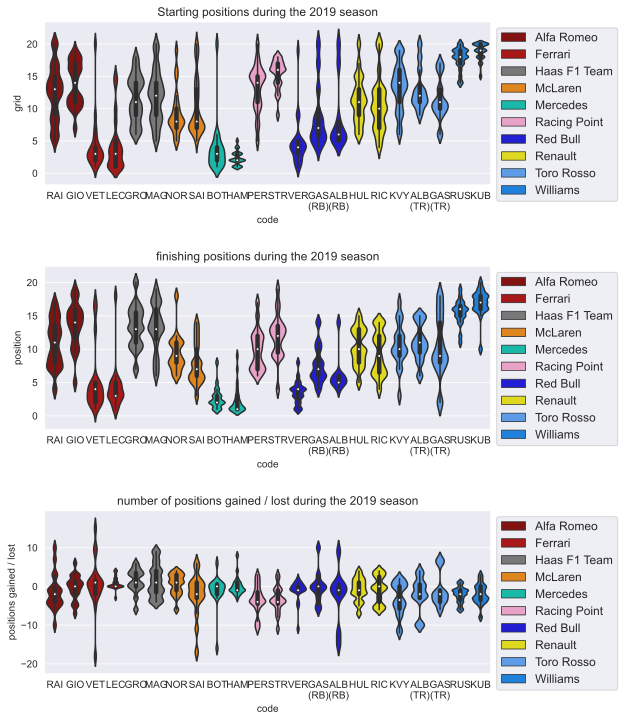

In [19]:
df, _ = plot_start_finish_data(2019, bw=0.2, scale="area");

On these plots, a smaller spread generally means the driver is more consistent in the top two plots. Although, one or two back-of-grid starts shouldn't penalize the driver too harshly, since it's likely due to a penalty due to a mechanical-related issue (i.e. engine change). 

There is a problem with this- This kind of analysis generally favors the back of the grid (sice they can only go forward) and punishes the front of the grid (since the can only go backward). At best, we can only gain objective insights into the midfield drivers, which we can call the middle 10. 

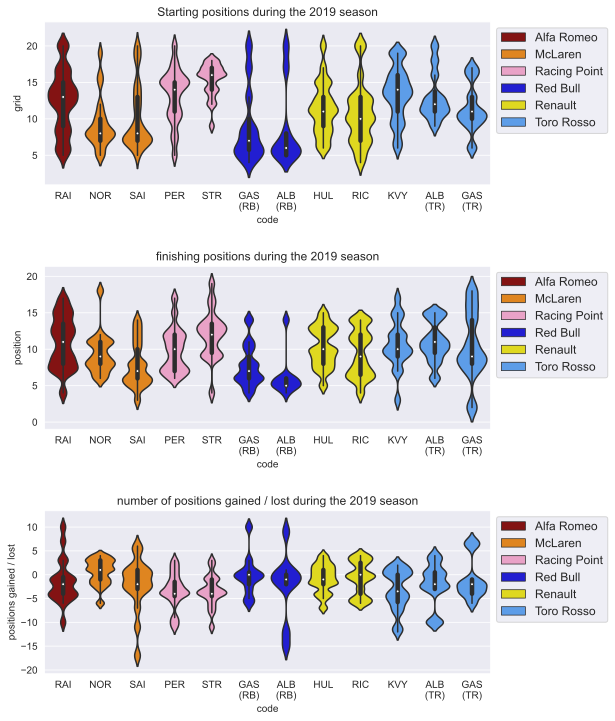

In [20]:
plot_start_finish_data(year=2019, df=df, remove_extremes=True, bw=0.2, scale="area");

( discussion goes here ) points to bring up: 
- negative values on the 3rd plot indicate positions gained (e.g. Vettel (VET) at some point in the 2019 season gained 19 positions in a race
- Gasley (GAS) seems much more suited for the Torro Rosso
- Leclerc and Hamilton seem to be remarkably consistent
- maybe add some more here

Observations from the top plot: 
- Hamilton's qualifying performance is incredibly consistent
- Albon beat Gasly in the Red Bull in qualifying performance, but Gasly beat Albon in the Torro Rosso. 
- Verstappen beat both of his teammates during 2019
- Haas, Alfa Romeo, and Renault are very inconsistent in qualifying

Middle plot: 
- Hamilton, Bottas, and Verstappen are the most consistent
- Large spread with Alfa, Renault, and Haas
- Albon was remarkably more consistent with finishing position in the RB than Gasly

Last plot: 
- Norris had a definitive net loss of position, eeryone else seemed to have gains (based on median- white dot)
- 

# 3 Retirements

A significant impact of a driver's performance over the course of a season is influenced by the car's reliability. For example, Daniel Riccardo in 2018 took a significant hit due to consecutive retirements during the summer. Let's take a look at which drivers had what retirements in 2019. 

In [21]:
def plot_retirements(year=2019, min_races=3, df=None):
    if df is None: 
        df = get_season_results(year=year, min_races=min_races, team_change=False)
    mechanical_dnf = ["Wheel", "Engine", "Out of Fuel", "Power Unit", "Transmission", "Brakes", "Suspension", 
                      "Power loss", "Exhaust", "Water pressure", "Hydraulics", "Overheating", "Oil leak", "Turbo", 
                      "Steering", "Gearbox", "Fuel pressure", "Mechanical", "Battery"]

    crash_dnf = ["Damage", "Collision damage", "Retired", "Collision", "Spun off", "Accident", "Disqualified", 
                 "Withdrew", "Out of fuel"]

    finish_status = ["Finished", "+1 Lap", "+2 Laps", "+3 Laps"]
    
    driver_standings = get_final_season_results(year=year, res="driver")
    constructor_standings = get_final_season_results(year=year, res="constructor")
    
    # make one plot for driver retirements for things related to crashes
    # make another plot for retirements related to mechanical issues, but order by team 
    df_driver = pd.DataFrame({'code': [driver for driver in df['code'].unique()], 
                              'dnfs': [len(df[(df['code']==driver) & (df['status'].isin(crash_dnf))]) 
                                       for driver in df['code'].unique()], 
                              'team': [df['team'][df['code']==driver].values[0] 
                                       for driver in df['code'].unique()], 
                              'points': [driver_standings['points'][driver_standings['code']==driver].values[0] 
                                        for driver in df['code'].unique()]
             }).sort_values(by='points', ascending=False)

    df_team = pd.DataFrame({'team': [team for team in df['team'].unique()], 
                            'dnfs': [len(df[(df['team']==team) & (df['status'].isin(mechanical_dnf))]) 
                                     for team in df['team'].unique()], 
                            'points': [constructor_standings['points'][constructor_standings['name']==team].values[0]
                                       for team in df['team'].unique()]
             }).sort_values(by='points', ascending=False)

    fig, ax = plt.subplots(nrows=2, figsize=[12, 5])
    plt.subplots_adjust(hspace=0.5)
    g = sns.barplot(x='code', y='dnfs', data=df_driver, ax=ax[0], hue='team', palette=colors, dodge=False);
    h = sns.barplot(x='team', y='dnfs', data=df_team, ax=ax[1], hue='team', palette=colors, dodge=False);
    
    g.legend_.remove()
    h.legend_.remove()
    
    ax[0].set_title("non-mechanical retirements by driver")
    ax[0].set_ylabel("number of\nnon-mechanical retirements")
    ax[1].set_title("mechanical retirements by team")
    ax[1].set_ylabel("number of\nmechanical retirements")
    return df_driver, df_team

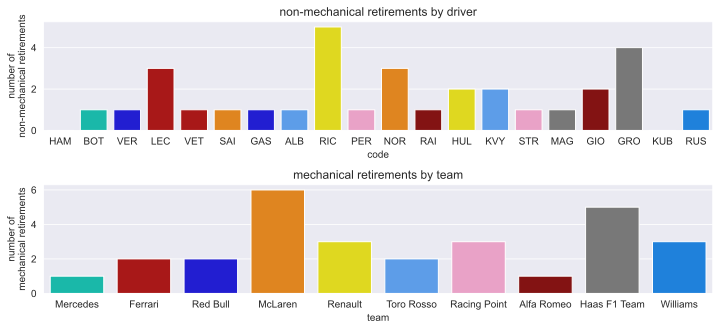

In [22]:
plot_retirements(year=2019);

- No non-mehcanical retirements for Hamilton, only one for Bottas. Mercedes has incredible reliability, same with Williams
- Riccardo and Grosjean are the worst offenders for non-mechanical reitrements
- Mclaren and Haas had the worst reliability (although McLaren still managed to get "best of the rest")

(discussion here)

# 4 Consistency

In this section, we'll plot the distribution of lap times over the course of a race. 

One of the ways to measure the quality of a driver is by their consistency. And one of the ways to measure consistency is to study the distribution of lap times during a race. To do that, we can use the coefficient of variaiton ($\frac{\sigma}{\mu}$) which is a way to measure the variances of sample distirbutions with different means. 

## 4.1 Filtering 

In order to make a fair comparison, we must only count racing laps- therefore we need to filter out the following: 
- first lap (usually slower than all the others while everyone gets up to speed)
- pit stops and the ensuing out lap 
- safety cars and virtual safety cars
- retired before a given portion of the race was complete (otherwise that particular race might give an unfair advantage to overall consistency since there were fewer samples. 

In [137]:
def filter_race(df=None, drop_values=False, first_lap=True, pit=True, pit_and_outlap=True, sc=True, 
               sc_cutoff=1.4, retirements=True, lap_cutoff=0.5, race="British", year=2020, 
               info=True): 
    
    """Filter race data as needed. 
    Parameters
    -----------
    df - race dataframe
    
    drop_values: boolean 
        If true, remove the offending indices. If false, set 'lap_time' to np.nan
    
    first_lap: boolean
        drop the first lap of the race
    
    
    """
    # get the average lap time of all the cars for each car. This will be returned for analysis. Maybe this should be 
    # combined with the get_race_traces function to avoid repetition
    # idea: do something that involves calculating the average lap time in 5 or 10 lap increments- find the gaps that 
    # represent the racing pace and determine the cutoff time from there piecewise
    
    # TODO: go through a bunch of races and find the most appropriate safety car cutoff
    # TODO: include boolean to return other_info
   
    finish_status = ["+1 Lap", "+2 Laps", "+3 Laps", "+4 Laps", "Finished"]
    if df is None: 
        df = get_race_distribution(race=race, year=year)
    df['dropped_laps'] = np.nan
    
    laps = df['lap'].sort_values().unique()
    times = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])
    avg_lap_time = np.nanmean(times)
    
    num_laps = max(laps)
    
    for driver in df['code'].unique(): 
        dropped = np.array([])
        
        if first_lap: 
            df = df.drop(df[df['lap']==1].index)
            dropped = np.append(dropped, 1)
            
        if pit_and_outlap:
            drop_laps = df['lap'][(df['code'] == driver) & (df['pit_lap'] == True)].values
            drop_laps2 = np.append(drop_laps, [lap+1 for lap in drop_laps])

            dropped = np.append(dropped, drop_laps2)
            df.drop(df[(df['code'] == driver) & (df['lap'].isin(drop_laps2))].index, inplace=True)
            
        elif pit: 
            dropped = np.append(dropped, df['lap'][df['pit_lap'] == True].values)
            
            df = df.drop(df[df['pit_lap'] == True].index)

        df['sc_detected'] = df['lap_time'] > sc_cutoff * avg_lap_time
        df.loc[df['code'] == driver, 'dropped_laps'] = str(dropped)
    if sc:
        
        sc_laps = df['lap'][df['sc_detected'] == True].unique()
        
       
        for lap in sc_laps: 
            if lap-1 not in sc_laps: 
                sc_laps = np.append(sc_laps, lap-1)
        sc_laps.sort()
        #print(sc_laps)
        df = df.drop(df[df['sc_detected'] == True].index)

        dropped = np.append(dropped, sc_laps)
        df = df.drop(df[df['lap'].isin(sc_laps)].index)

    df['dropped_laps'] = df['dropped_laps'] + str(sc_laps)
        
    # Throw out dirvers that did not complete a certain percentage of the race. This throws out drivers that retired 
    # early in the race while keeping those that may have retired in the later stages since they will still have a 
    # substantial number of lap times

    if retirements: 
        for driver in df['code'].unique(): 
            if (df['status'][df['code'] == driver].values[0] not in finish_status) &\
               (len(df[df['code'] == driver]) < lap_cutoff * num_laps): 
                
                df = df.drop(df[df['code'] == driver].index)
    if sc & info: 
        return df, times, avg_lap_time, sc_laps
    elif info: 
        return df, times, avg_lap_time
    else: 
        return df

In [138]:
test = filter_race(get_race_distribution(race="British", year=2019))
test[0].head()

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status,team,dropped_laps,sc_detected
51,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 20. 21.][20 21 22 23],False
98,47,87.406,False,2,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 16. 46. 17.][20 21 22 23],False
100,49,88.399,False,2,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 16. 46. 17.][20 21 22 23],False
40,41,88.568,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 20. 21.][20 21 22 23],False
42,43,88.622,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 20. 21.][20 21 22 23],False


sc laps: [20 21 22 23]


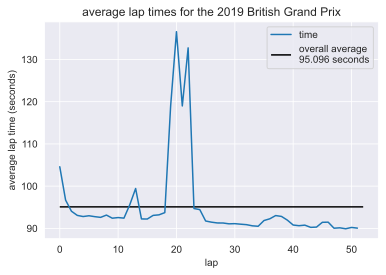

In [125]:
print(f"sc laps: {test[3]}")

fig, ax = plt.subplots()
plt.plot(test[1], label="time")
ax.hlines(y=test[2], color='k', xmin=0, xmax=52, label=f"overall average\n{round(test[2], 3)} seconds")
ax.set_title("average lap times for the 2019 British Grand Prix")
ax.set_xlabel("lap")
ax.set_ylabel("average lap time (seconds)");
ax.legend();

These values make sense, so we can now try examining the distribution of lap times for each driver

## 4.2 Plotting lap time distribution for 1 race

In [126]:
def get_finishing_order(race, year):
    results_text = f"""
    SELECT results.positionorder, 
           drivers.code
    FROM results
    JOIN races ON races.raceid = results.raceid
    JOIN drivers ON drivers.driverid = results.driverid
    WHERE races.year = {year} AND races.name iLike '%{race}%' 
    
    ORDER BY results.positionorder
    """
    results_df = query(results_text); 
    return results_df

def plot_race_distribution(race, year, outliers=False, whis=1.5, cutoff=1.2, colors=colors, bw=1.2, 
                           drop_first_lap=True, drop_pit=True, drop_out_lap=True, style="darkgrid"): 
    """Plot the distribution of lap times over the course of a race"""
    
    df = get_race_distribution(race=race, year=year);
 
    fastest_lap = df['lap_time'].min()
    slowest_lap = df['lap_time'].max()
    
    laps = df['lap'].unique()
    laps.sort()
    
    df = filter_race(df, info=False) 
    
    # get the finishing order
    finishing_order = get_finishing_order(race=race, year=year)['code'].to_numpy()
    
    sns.set_style(style)
    fig, ax = plt.subplots(figsize=[9, 4])
    
    # make plots
    sns.violinplot(ax=ax, 
                   data=df, 
                   y="lap_time", 
                   x="code", 
                   hue="team", 
                   palette=colors, 
                   order=finishing_order, 
                   showfliers=outliers,
                   dodge=False, 
                   bw=bw
                  )
    
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=12)
    
    #plt.xticks(rotation=30, horizontalalignment='center')
    ax.set_xlabel("driver", fontsize=12)
    ax.set_ylabel("lap time (seconds)", fontsize=12),
    ax.set_ylim([(fastest_lap-0.5), fastest_lap*(cutoff)+2])
    ax.tick_params(labelsize=10)
    ax.autoscale(enable=True)
    ax.set_title(f"Lap time distribution for the {year} {df['name'].values[0]}\n", fontsize=15)
    return ax, df

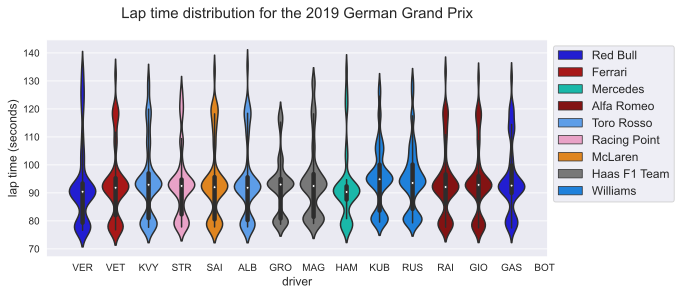

In [127]:
ax, df = plot_race_distribution(race="German", year=2019, cutoff=1.2, bw=0.2);

It looks like there are a couple outliers for Verstappen and Vettel- what's goin on with these laps? 

In [128]:
df[df['code']=="VER"].sort_values(by='lap_time', ascending=False).head()

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status,team,dropped_laps,sc_detected
62,33,134.580,False,1,Max,Verstappen,VER,German Grand Prix,2019,Finished,Red Bull,[ 1. 46. 25. 41. 3. 29. 47. 26. 42. 4. 30.][...,False
24,59,130.518,False,1,Max,Verstappen,VER,German Grand Prix,2019,Finished,Red Bull,[ 1. 46. 25. 41. 3. 29. 47. 26. 42. 4. 30.][...,False
8,43,127.412,False,1,Max,Verstappen,VER,German Grand Prix,2019,Finished,Red Bull,[ 1. 46. 25. 41. 3. 29. 47. 26. 42. 4. 30.][...,False
23,58,124.908,False,1,Max,Verstappen,VER,German Grand Prix,2019,Finished,Red Bull,[ 1. 46. 25. 41. 3. 29. 47. 26. 42. 4. 30.][...,False
10,45,122.356,False,1,Max,Verstappen,VER,German Grand Prix,2019,Finished,Red Bull,[ 1. 46. 25. 41. 3. 29. 47. 26. 42. 4. 30.][...,False


In [129]:
df[df['code']=="VET"].sort_values(by='lap_time', ascending=False).head()

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status,team,dropped_laps,sc_detected
96,33,132.267,False,8,Sebastian,Vettel,VET,German Grand Prix,2019,Finished,Ferrari,[ 1. 47. 23. 2. 41. 28. 48. 24. 3. 42. 29.][...,False
121,58,120.494,False,5,Sebastian,Vettel,VET,German Grand Prix,2019,Finished,Ferrari,[ 1. 47. 23. 2. 41. 28. 48. 24. 3. 42. 29.][...,False
122,59,119.763,False,5,Sebastian,Vettel,VET,German Grand Prix,2019,Finished,Ferrari,[ 1. 47. 23. 2. 41. 28. 48. 24. 3. 42. 29.][...,False
108,45,118.984,False,9,Sebastian,Vettel,VET,German Grand Prix,2019,Finished,Ferrari,[ 1. 47. 23. 2. 41. 28. 48. 24. 3. 42. 29.][...,False
67,4,118.171,False,12,Sebastian,Vettel,VET,German Grand Prix,2019,Finished,Ferrari,[ 1. 47. 23. 2. 41. 28. 48. 24. 3. 42. 29.][...,False


Based on the [highlights](https://youtu.be/TjiCXhGuLgw?t=333), the increased lap time is due to a collision between Vettel and Verstappen, which is exactly the sort of thing that we want to keep in the data, suggesting that this filtering is effective. Unfortunately, the collision was only Vettel's fault, so Verstappen really shouldn't be peanalized for it, but that distinction is not present in the data so we will keep it as is. 

# 4.3 Coefficients of variation over a season

One way to judge the overall consistency of a driver is to look at the distribution of lap times during a race. The hypothesis here is that the better drivers are the one that put in more consistent lap times. This is affected by tyre choice, since the stiffness of tire compounds directly influence lap time; however, we can run under the assumption that these differences average out over a season. 

To remove the effects of the different average lap times for each circuit, we calculate the coefficient of variation $c_v = \frac{\sigma}{\mu}$ ($\sigma$ = standard deviation, $\mu$ = average) for each race and investigate the spread of variations for each driver. 

First, define a function to get the season finishing order. This may be filled in with a previous function that has simlar functionality.

In [130]:
def get_season_finishing_order(year): 
    
    results_text = f"""
    SELECT driver_standings.position, driver_standings.points, drivers.code, drivers.forename, drivers.surname
    FROM driver_standings
    JOIN drivers ON drivers.driverid = driver_standings.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year} AND races.round = (SELECT MAX(races.round) FROM races WHERE races.year = {year})
    """
    results_df = query(results_text).sort_values(by='points', ascending=False);
    return results_df

In [170]:
def calc_variations(year=2020, plot=True, team_abbrev=team_abbrev, bw=.15): 
    """Plot the distrubution of lap time variations for each driver over the course of a season.
    
    Parameters
    -------
    year: selected year (2020 default)
    plot: if true, plots are automatically generated, if false, only calculated data frames are returned
    team_abbrev: dictionary of team abbreviations. In the case of mid season driver changes (e.g. Pierre Gasly and 
        Alex Albon's swap in 2019), the lap time distribution is segregated between each team and the team abbreviation
        is appended to the driver code for better discernment. 
    
    Returns
    -------
    df: merged DataFrame containing the race variation info and season results
    season_results: DataFrame containing the standings at the end of the selected season
    race_data: DataFrame with the coefficient of variation for each race for each driver
    Axes: array with the 2 axis handles for each plot (only returned if plot is True)
    """
    
    races_query = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """
    
    drivers_query = f"""
    SELECT DISTINCT drivers.code
    FROM drivers
    JOIN driver_standings ON driver_standings.driverid = drivers.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year}
    """
    # set font sizes for axes
    LARGE_FONT = 18
    MED_FONT   = 12
    SMALL_FONT = 9
    
    # Get all the races in a single season.
    races = query(races_query)['name'].to_numpy() 
    
    # races = np.delete(races, "German Grand Prix")
    # get the drivers for a given season
    drivers = query(drivers_query)['code'].to_numpy()             
    
    # initialize a dataframe for the coefficients of variation in every race
    race_data = pd.DataFrame(columns = ['race', 'team',  'coef_of_var', 'laps_counted', 'status'])
    
    # get the final season standings
    season_results = get_season_finishing_order(year)
    
    # loop through each race and calculate the coefficient of variation for each driver
    for race in races: 

            
        try:
            race_dist = filter_race(get_race_distribution(race, year), info=False) 
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
        
        num_laps = max(race_dist['lap'].values)
        num_finishers = len(race_dist['code'].unique())
        
        #print(f"race: {race}; num_laps: {num_laps}; num_finishers: {num_finishers}")
        
        # loop through each driver
        for driver in race_dist['code'].unique():
            lap_times = race_dist['lap_time'][race_dist['code'] == driver].values
            laps = race_dist['lap'][race_dist['code'] == driver].values
            
            # Calculate average and standard deviation. 
            avg  = np.nanmean(lap_times)
            sd   = np.nanstd(lap_times)
            
            # Get other needed metrics
            team = race_dist['team'][race_dist['code'] == driver].values[0]
            status = race_dist['status'][race_dist['code'] == driver].values[0]
            max_lap = str(max(laps))
            
            laps_counted = str(len(laps)) + "/" + str(max(laps))
            #print(f"driver: {driver}, laps completed: {len(laps)}")
            # append to dataframe

            race_data = race_data.append({'race'       : race,
                                          'code'       : driver, 
                                          'team'       : team, 
                                          'status'     : status, 
                                          'laps_counted': laps_counted,
                                          'coef_of_var': sd/avg}, 
                                           ignore_index=True)
            
    # merge the race data and season results to properly order the drivers
    df = pd.merge(race_data, season_results, left_on='code', right_on='code')

    # handle mid-season driver switches
    # add team abbreviation to driver code if they drove for multiple teams in the same season
    df = team_switches(df)

            
    # return the dataframes if we're not plotting anything
    if plot == False: 
         return df, season_results, race_data
        
     # make box plots, order by drivers standings
    fig, ax = plt.subplots(nrows=2, figsize=[8,8])
    
    plt.subplots_adjust(hspace=0.7)
    sns.violinplot(data=df, 
                   x='code',
                   y='coef_of_var', 
                   ax=ax[0], 
                   hue='team', 
                   palette=colors, 
                   dodge=False,
                   bw=bw, 
                   order=df.sort_values(by='points', ascending=False)['code'].unique()
                   )

    ax[0].set_title(f"\nCoefficient of variation distributions for the {year} season\nordered by driver standings\n", 
                    fontsize=LARGE_FONT)
    

    # order by average coefficient of variation
    order_var = pd.DataFrame(columns = ['code', 'avg_coef_of_var'])
    
    for driver in df['code'].unique(): 
        avg_var = np.nanmean(df['coef_of_var'][df['code']==driver])
        order_var = order_var.append({'code': driver, 'avg_coef_of_var': avg_var}, ignore_index=True)

    sns.violinplot(data=df, 
                x=df['code'], 
                y='coef_of_var', 
                ax=ax[1], 
                hue='team', 
                palette=colors, 
                dodge=False,
                bw=bw,
                order=order_var.sort_values(by='avg_coef_of_var')['code'].to_numpy()
               )

    ax[1].set_title(f"\nCoefficient of variation distributions for the {year} season\nordered by lowest average variation\n",
                    fontsize = LARGE_FONT)
    
    # format axes
    for i in [0,1]:
        ax[i].set_xlabel("driver\n",                 fontsize=MED_FONT)
        ax[i].set_ylabel("coefficient of variation", fontsize=MED_FONT)
        ax[i].tick_params(axis='x',                  labelsize=SMALL_FONT)
        ax[i].tick_params(axis='y',                  labelsize=SMALL_FONT)
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=MED_FONT)
    return df, season_results, race_data, [ax[0], ax[1]]

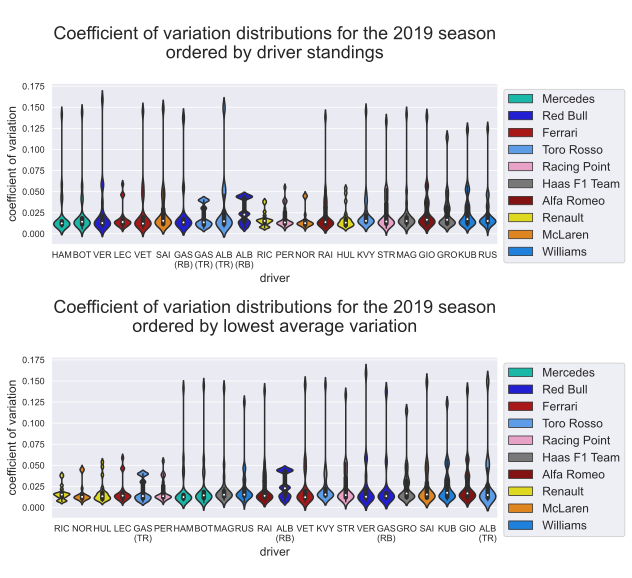

In [173]:
cons_df, season_results, race_data, axes = calc_variations(year=2019, plot=True);

Which drivers had the most / least consistent races? 

In [174]:
print("least consistent races")
cons_df.sort_values(by='coef_of_var', ascending=False).head(10)

least consistent races


,race,team,coef_of_var,laps_counted,status,code,position,points,forename,surname
52,German Grand Prix,Red Bull,0.158974,51/64,Finished,VER,3,278,Max,Verstappen
191,German Grand Prix,Toro Rosso,0.149364,53/64,Finished,ALB\n(TR),8,92,Alexander,Albon
350,German Grand Prix,McLaren,0.148489,53/64,Finished,SAI,6,96,Carlos,Sainz
152,German Grand Prix,Ferrari,0.145182,50/64,Finished,VET,5,240,Sebastian,Vettel
111,German Grand Prix,Toro Rosso,0.145038,52/64,Finished,KVY,13,37,Daniil,Kvyat
10,German Grand Prix,Mercedes,0.143912,45/56,Accident,BOT,2,326,Valtteri,Bottas
170,German Grand Prix,Haas F1 Team,0.141469,49/64,Finished,MAG,16,20,Kevin,Magnussen
31,German Grand Prix,Mercedes,0.141210,50/64,Finished,HAM,1,413,Lewis,Hamilton
251,German Grand Prix,Alfa Romeo,0.138785,52/64,Finished,GIO,17,14,Antonio,Giovinazzi
212,German Grand Prix,Alfa Romeo,0.138200,52/64,Finished,RAI,12,43,Kimi,Räikkönen


In [175]:
print("most consistent races")
cons_df.sort_values(by='coef_of_var', ascending=True).head(10)

most consistent races


,race,team,coef_of_var,laps_counted,status,code,position,points,forename,surname
315,Singapore Grand Prix,Williams,0.005796,32/34,Collision,RUS,20,0,George,Russell
8,Austrian Grand Prix,Mercedes,0.005832,68/71,Finished,BOT,2,326,Valtteri,Bottas
142,Australian Grand Prix,Ferrari,0.006408,55/58,Finished,VET,5,240,Sebastian,Vettel
96,Japanese Grand Prix,Toro Rosso,0.006599,48/51,+1 Lap,GAS\n(TR),7,95,Pierre,Gasly
137,Japanese Grand Prix,Racing Point,0.006835,48/51,+1 Lap,STR,15,21,Lance,Stroll
68,Austrian Grand Prix,Ferrari,0.006980,68/71,Finished,LEC,4,264,Charles,Leclerc
360,Chinese Grand Prix,Renault,0.007070,51/55,+1 Lap,RIC,9,54,Daniel,Ricciardo
300,Abu Dhabi Grand Prix,McLaren,0.007081,50/54,+1 Lap,NOR,11,49,Lando,Norris
60,Abu Dhabi Grand Prix,Red Bull,0.007282,51/55,Finished,VER,3,278,Max,Verstappen
201,Abu Dhabi Grand Prix,Red Bull,0.007427,51/55,Finished,ALB\n(RB),8,92,Alexander,Albon


- List of observations: 

- German grand prix is throwing things out of wack
- Some of the drivers are benefiting becuase they retired from the German Grand Prix becuase conditions changed significantly about halfway through the race
- Riccardo was the most consistent
- these are very sensitive to how the laps are filtered
- The project is being continually tweaked to get the most representative results possible
- There is clearly no significant difference in the distribution of lap times over the course of a season, meaning this metric is likely not a good indicator of driver quality judging by how much these measure appear to be down to luck. 

# 5 conclusion

- As expected, pin-pointing the best drivers independent of car performance is an incredibly difficult task. 
- Evaluated several key metrics as they relate to the 2019 season

- No statistical significance in any of these distributions / spreads- that's part of the reason why this kind of discussion is so difficult and subjective

# 6 planned updates

Further ideas: 
- make a plot of the distribution of deltas (divided by average lap time) over all the races to directly compare teammates
- Finish aggregating statuses

Start / finish plots
- adjust order, do a second plot with the top 3 and bottom 3 in the championship standings thrown out, maybe group by team
- go through full data cleaning process

- add a table with team, hex code, and year to account for livery changes

filtering: 
- use cumulative lap times and average lap time to determine if a driver is a lap down on a given lap 
- rewrite to have this flow-- for each option, collect all the indices of the offending lap times, the at the 
  end modify the df depending on the value of drop_values